# Compute relationship between size and syllable use

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.plotting import figure, legend, format_plots, COLORMAPS, PLOT_CONFIG, save_factory, PlotConfig
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests

In [2]:
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
#m_df= male_df.groupby(['age','uuid']).mean()
m_df= male_df.copy()

In [5]:
size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
)
age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

# sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[m_df.index]

# make sure df matches sizes
m_df = m_df.loc[sizes_col.index]
age = m_df.index.get_level_values("age")

In [6]:
m_df['size'] = sizes_col

In [7]:
corrs = m_df.corr(method="spearman").loc["size"].iloc[:-1]

In [8]:
corr_sig_df = []
for syll in m_df.columns[:-1]:
    c = spearmanr(m_df[syll], m_df['size'])
    corr_sig_df.append(dict(syllable=syll, rho=c.statistic, p=c.pvalue))
corr_sig_df = pd.DataFrame(corr_sig_df)
corr_sig_df['adj_p'] = multipletests(corr_sig_df['p'], method='bonferroni')[1]

In [9]:
print(sum(corr_sig_df['adj_p']<0.05))

34


In [10]:
corr_sig_df.to_csv('/n/groups/datta/Dana/Ontogeny/figs/fig1/male_size_correlations_07_08_spearman.csv')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


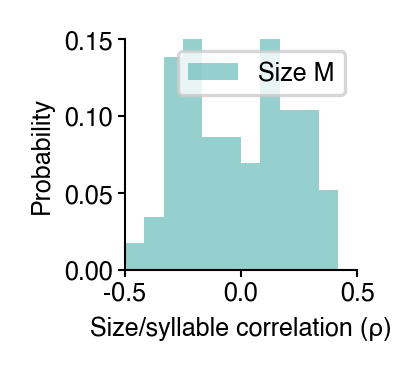

In [11]:
fig = figure(1, 1)
ax = sns.histplot(
    [corrs.rename("Size M")],
    palette=[COLORMAPS.ont_male(155)],
    bins=np.linspace(-0.5, 0.5, 13),
    stat="probability",
    alpha=0.6,
    element='step',
    linewidth=0,
)
ax.set(
    xlabel="Size/syllable correlation (ρ)",
    #title="Correlation between mouse area and syllable usage",
    xlim=(-0.5, 0.5),
    ylim=(0, 0.15),
)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'size_males_histogram_spearman.pdf')

In [12]:
## pearson correlation

In [13]:
corrs = m_df.corr(method='pearson').loc["size"].iloc[:-1]
corr_sig_df = []
for syll in m_df.columns[:-1]:
    c = pearsonr(m_df[syll], m_df['size'])
    corr_sig_df.append(dict(syllable=syll, rho=c.statistic, p=c.pvalue))
corr_sig_df = pd.DataFrame(corr_sig_df)
corr_sig_df['adj_p'] = multipletests(corr_sig_df['p'], method='bonferroni')[1]
corr_sig_df.to_csv('/n/groups/datta/Dana/Ontogeny/figs/fig1/male_size_correlations_07_08_peasron.csv')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


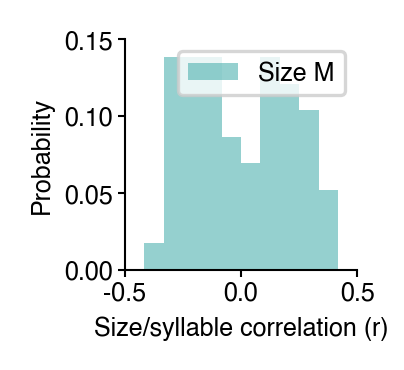

In [14]:
fig = figure(1, 1)
ax = sns.histplot(
    [corrs.rename("Size M")],
    palette=[COLORMAPS.ont_male(155)],
    bins=np.linspace(-0.5, 0.5, 13),
    stat="probability",
    alpha=0.6,
    element='step',
    linewidth=0,
)
ax.set(
    xlabel="Size/syllable correlation (r)",
    #title="Correlation between mouse area and syllable usage",
    xlim=(-0.5, 0.5),
    ylim=(0, 0.15),
)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'size_males_histogram_pearson.pdf')

In [15]:
print(sum(corr_sig_df['adj_p']<0.05))

31


In [16]:
m_df.set_index('size', inplace=True, append=True)

In [17]:
# Initialize lists to store slopes and intercepts
from scipy.stats import linregress
slopes = []
intercepts = []
for column in m_df.columns:
    y = m_df[column]
    x = m_df.index.get_level_values('size')
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes.append(slope)
    intercepts.append(intercept)
# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Slope': slopes, 'Intercept': intercepts})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

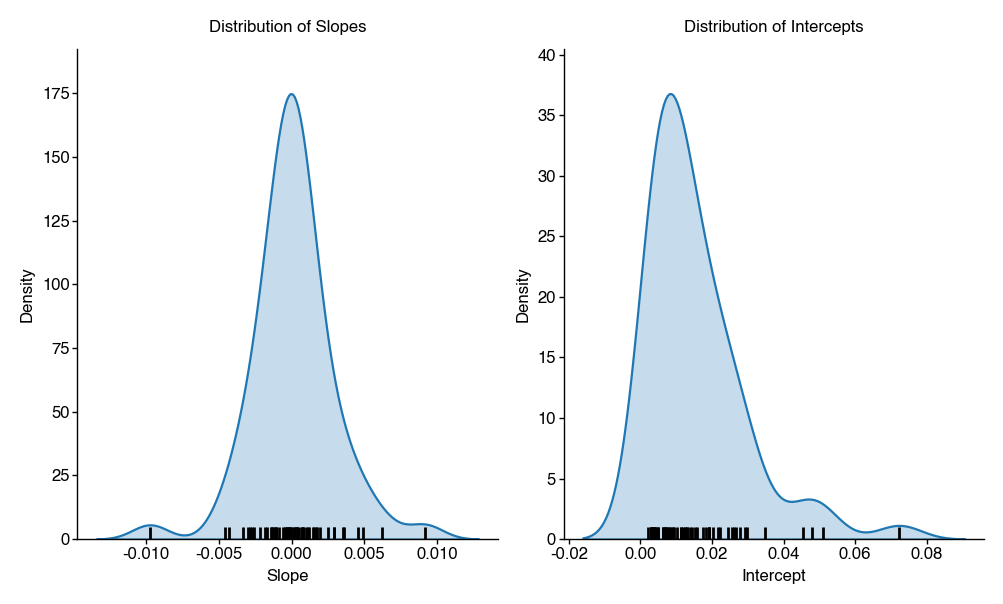

In [18]:
# Plotting the distributions
plt.figure(figsize=(5, 3))

# Distribution of slopes
plt.subplot(1, 2, 1)
sns.kdeplot(df_plot['Slope'], fill=True)
sns.rugplot(df_plot['Slope'], color='black')
plt.title('Distribution of Slopes')
plt.xlabel('Slope')
plt.ylabel('Density')

# Distribution of intercepts
plt.subplot(1, 2, 2)
sns.kdeplot(df_plot['Intercept'], fill=True)
sns.rugplot(df_plot['Intercept'], color='black')
plt.title('Distribution of Intercepts')
plt.xlabel('Intercept')
plt.ylabel('Density')
sns.despine()
plt.tight_layout()
plt.show()

In [19]:
df_male=m_df.copy()
df_male['sex'] = 'm'
df_male.set_index('sex', append=True, inplace=True)

## Females

In [20]:
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df=female_df.copy()

# for female:
#f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']

# Save the original index
original_index = f_df.index.names

f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
#f_df.set_index(['age', 'uuid'], inplace=True)
f_df.set_index(original_index, inplace=True)

#f_df=female_df.copy()
f_df=f_df.query('age<127')

In [21]:
size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
)
# Save the original index
original_index = size_df.index.names
size_df.reset_index(inplace=True)
size_df.loc[size_df['uuid'].isin(uuids), 'age'] = 52
size_df['age'] = size_df['age'].map(age_mapping).fillna(size_df['age'])
# Set the index back
size_df.set_index(original_index, inplace=True)

age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

# sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[f_df.index]

# make sure df matches sizes
f_df = f_df.loc[sizes_col.index]
age = f_df.index.get_level_values("age")

In [22]:
f_df['size'] = sizes_col

In [23]:
corrs = f_df.corr(method="spearman").loc["size"].iloc[:-1]

In [24]:
corr_sig_df = []
for syll in f_df.columns[:-1]:
    c = spearmanr(f_df[syll], f_df['size'])
    corr_sig_df.append(dict(syllable=syll, rho=c.statistic, p=c.pvalue))
corr_sig_df = pd.DataFrame(corr_sig_df)
corr_sig_df['adj_p'] = multipletests(corr_sig_df['p'], method='bonferroni')[1]

In [25]:
corr_sig_df.to_csv('/n/groups/datta/Dana/Ontogeny/figs/fig1/female_size_correlations_07_08_spearman.csv')

In [26]:
print(sum(corr_sig_df['adj_p']<0.05))

36


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


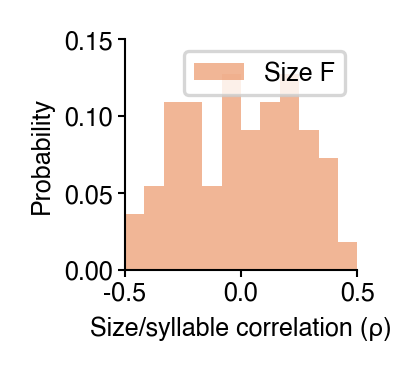

In [27]:
fig = figure(1, 1)
ax = sns.histplot(
    [corrs.rename("Size F")],
    palette=[COLORMAPS.ont_female(155)],
    bins=np.linspace(-0.5, 0.5, 13),
    stat="probability",
    alpha=0.6,
    element='step',
    linewidth=0,
)
ax.set(
    xlabel="Size/syllable correlation (ρ)",
    #title="Correlation between mouse area and syllable usage",
    xlim=(-0.5, 0.5),
    ylim=(0, 0.15),
)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'size_females_histogram_spearman.pdf')

In [28]:
f_df.set_index('size', inplace=True, append=True)

In [29]:
# Initialize lists to store slopes and intercepts
for column in f_df.columns:
    y = f_df[column]
    x = f_df.index.get_level_values('size')
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes.append(slope)
    intercepts.append(intercept)
# Create a DataFrame for plotting
df_plot_f = pd.DataFrame({'Slope': slopes, 'Intercept': intercepts})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

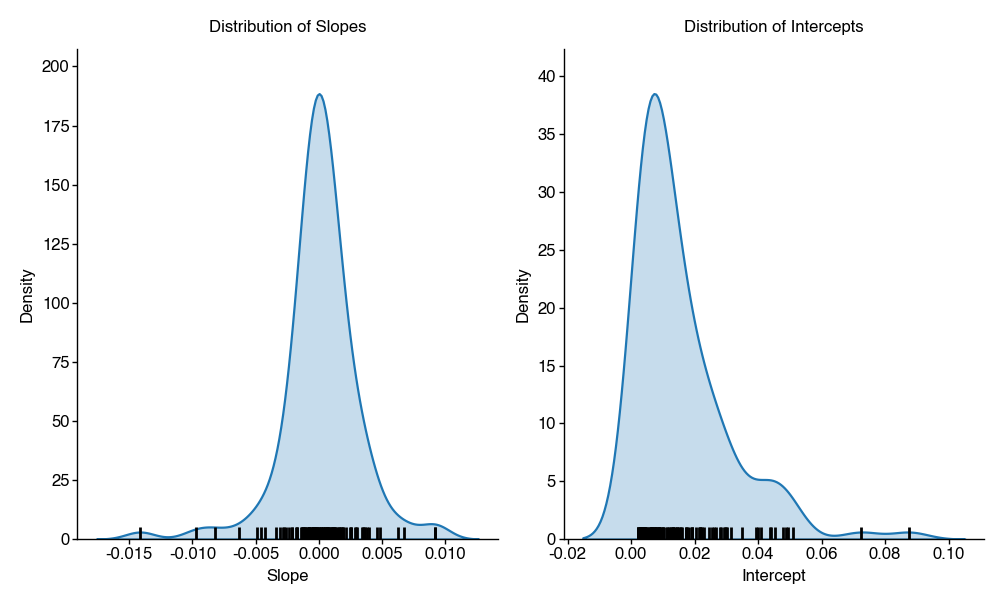

In [30]:
# Plotting the distributions
plt.figure(figsize=(5, 3))

# Distribution of slopes
plt.subplot(1, 2, 1)
sns.kdeplot(df_plot_f['Slope'], fill=True)
sns.rugplot(df_plot_f['Slope'], color='black')
plt.title('Distribution of Slopes')
plt.xlabel('Slope')
plt.ylabel('Density')

# Distribution of intercepts
plt.subplot(1, 2, 2)
sns.kdeplot(df_plot_f['Intercept'], fill=True)
sns.rugplot(df_plot_f['Intercept'], color='black')
plt.title('Distribution of Intercepts')
plt.xlabel('Intercept')
plt.ylabel('Density')
sns.despine()
plt.tight_layout()
plt.show()

In [31]:
df_female=f_df.copy()
df_female['sex'] = 'f'
df_female.set_index('sex', append=True, inplace=True)

In [32]:
### comparte to male/females

In [33]:
df = pd.concat([df_male,df_female])

In [34]:
df=df.groupby(['age','uuid','sex','size']).mean()

In [35]:
#df = np.log(df + 1e-6)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

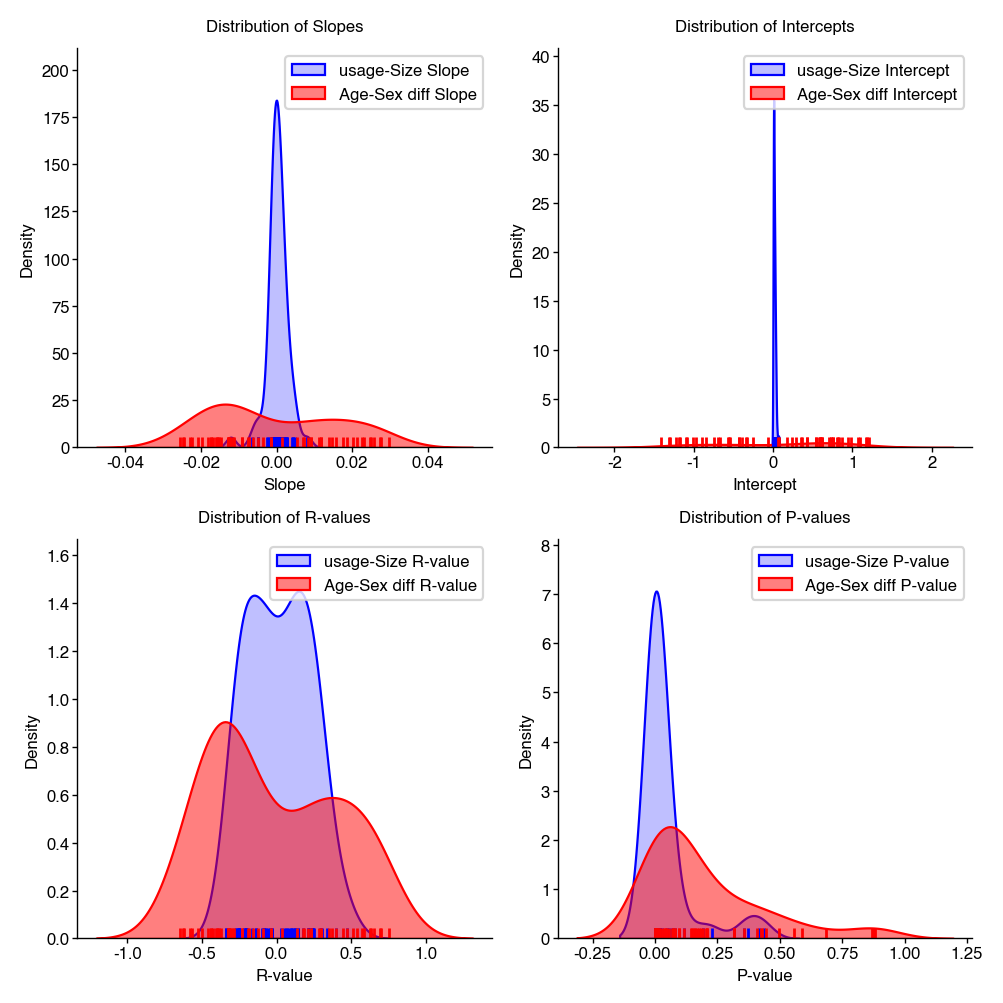

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

# Initialize lists to store slopes, intercepts, r-values, and p-values
size_slopes = []
size_intercepts = []
size_r_values = []
size_p_values = []
age_sex_slopes = []
age_sex_intercepts = []
age_sex_r_values = []
age_sex_p_values = []

# Perform linear regression for each syllable as a function of size
for column in df.columns:
    y = df[column]
    x = df.index.get_level_values('size')
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    size_slopes.append(slope)
    size_intercepts.append(intercept)
    size_r_values.append(r_value)
    size_p_values.append(p_value)

# Perform linear regression for the difference between males and females as a function of age
for column in df.columns:
    mdf = df[df.index.get_level_values('sex') == 'm'][column]
    fdf = df[df.index.get_level_values('sex') == 'f'][column]
    
    f_ages = fdf.index.get_level_values('age').unique().to_numpy()
    m_ages = mdf.index.get_level_values('age').unique().to_numpy()
    common_ages = list(np.intersect1d(f_ages,m_ages))
    #common_ages = male_df.index.intersection(female_df.index).get_level_values('age')
    mdf = mdf.loc[mdf.index.get_level_values('age').isin(common_ages)]
    fdf = fdf.loc[fdf.index.get_level_values('age').isin(common_ages)]
    
    # Calculate difference
    diff = mdf.groupby('age').mean().values - fdf.groupby('age').mean().values
    age = common_ages
    
    # Standardize the differences
    scaler = StandardScaler()
    standardized_diff = scaler.fit_transform(diff.reshape(-1, 1)).flatten()
    
    slope, intercept, r_value, p_value, std_err = linregress(age, standardized_diff)
    age_sex_slopes.append(slope)
    age_sex_intercepts.append(intercept)
    age_sex_r_values.append(r_value)
    age_sex_p_values.append(p_value)

# Create DataFrame for plotting
size_df = pd.DataFrame({'Slope': size_slopes, 'Intercept': size_intercepts, 'R-value': size_r_values, 'P-value': size_p_values})
age_sex_df = pd.DataFrame({'Slope': age_sex_slopes, 'Intercept': age_sex_intercepts, 'R-value': age_sex_r_values, 'P-value': age_sex_p_values})

# Plotting the distributions of slopes and intercepts
plt.figure(figsize=(5, 5))

# Distribution of slopes
plt.subplot(2, 2, 1)
sns.kdeplot(size_df['Slope'], fill=True, color='blue', label='usage-Size Slope')
sns.rugplot(size_df['Slope'], color='blue')
sns.kdeplot(age_sex_df['Slope'], fill=True, color='red', alpha=0.5, label='Age-Sex diff Slope')
sns.rugplot(age_sex_df['Slope'], color='red')
plt.title('Distribution of Slopes')
plt.xlabel('Slope')
plt.ylabel('Density')
plt.legend()

# Distribution of intercepts
plt.subplot(2, 2, 2)
sns.kdeplot(size_df['Intercept'], fill=True, color='blue', label='usage-Size Intercept')
sns.rugplot(size_df['Intercept'], color='blue')
sns.kdeplot(age_sex_df['Intercept'], fill=True, color='red', alpha=0.5, label='Age-Sex diff Intercept')
sns.rugplot(age_sex_df['Intercept'], color='red')
plt.title('Distribution of Intercepts')
plt.xlabel('Intercept')
plt.ylabel('Density')
plt.legend()

# Distribution of r-values
plt.subplot(2, 2, 3)
sns.kdeplot(size_df['R-value'], fill=True, color='blue', label='usage-Size R-value')
sns.rugplot(size_df['R-value'], color='blue')
sns.kdeplot(age_sex_df['R-value'], fill=True, color='red', alpha=0.5, label='Age-Sex diff R-value')
sns.rugplot(age_sex_df['R-value'], color='red')
plt.title('Distribution of R-values')
plt.xlabel('R-value')
plt.ylabel('Density')
plt.legend()

# Distribution of p-values
plt.subplot(2, 2, 4)
sns.kdeplot(size_df['P-value'], fill=True, color='blue', label='usage-Size P-value')
sns.rugplot(size_df['P-value'], color='blue')
sns.kdeplot(age_sex_df['P-value'], fill=True, color='red', alpha=0.5, label='Age-Sex diff P-value')
sns.rugplot(age_sex_df['P-value'], color='red')
plt.title('Distribution of P-values')
plt.xlabel('P-value')
plt.ylabel('Density')
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

In [37]:
df.reset_index(level='uuid', drop=True, inplace=True)
df=np.log(df+1e-6)

In [38]:
df.reset_index(inplace=True)

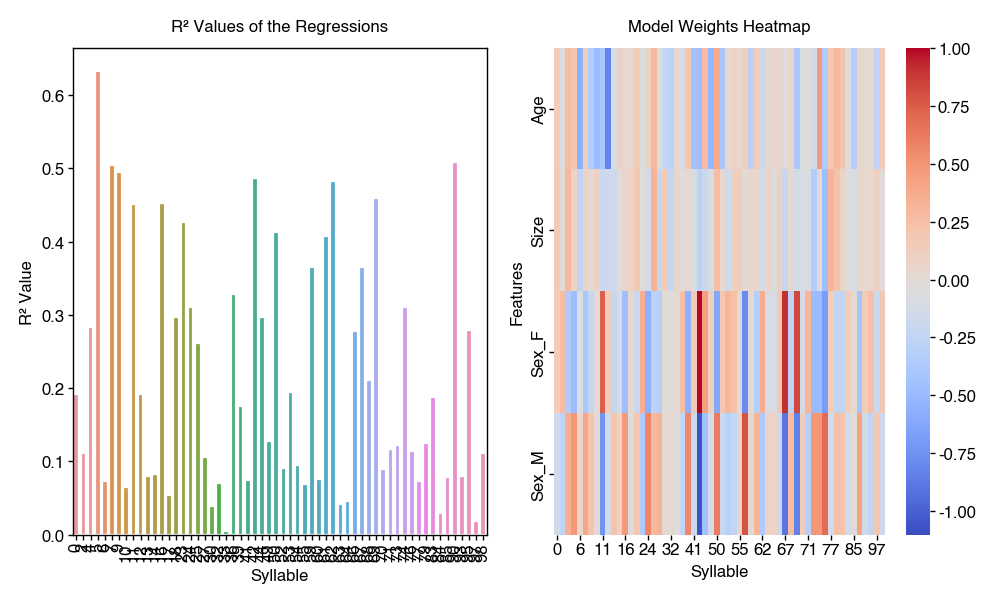

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# Define the predictors and response variables
X = df[['age', 'sex', 'size']]
y = df[df.columns[3:]]  # Exclude 'Age', 'Sex', and 'Size' from the response variables

# One-hot encode the 'Sex' variable
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'size']),
        ('cat', OneHotEncoder(), ['sex'])
    ])

# Initialize ElasticNet model with alpha=0.01
#elastic_net = ElasticNet(alpha=0.1)
elastic_net = LinearRegression()

# Initialize lists to store R² values and model weights
r2_values = []
model_weights = []

# Perform linear regression for each syllable
for column in y.columns:
    y_col = y[column]
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', elastic_net)])
    pipe.fit(X, y_col)
    
    y_pred = pipe.predict(X)
    r2_values.append(r2_score(y_col, y_pred))
    
    # Get model coefficients
    coefficients = pipe.named_steps['regressor'].coef_
    intercept = pipe.named_steps['regressor'].intercept_
    #model_weights.append(np.append(intercept, coefficients))
    model_weights.append(coefficients)

# Create DataFrame for model weights
#weights_df = pd.DataFrame(model_weights, columns=['Intercept', 'Age', 'Size', 'Sex_F', 'Sex_M'], index=y.columns)
weights_df = pd.DataFrame(model_weights, columns=['Age', 'Size', 'Sex_F', 'Sex_M'], index=y.columns)

# Plotting R² values
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
sns.barplot(x=y.columns, y=r2_values)
plt.xticks(rotation=90)
plt.title('R² Values of the Regressions')
plt.xlabel('Syllable')
plt.ylabel('R² Value')

# Plotting model weights as a heatmap
plt.subplot(1, 2, 2)
sns.heatmap(weights_df.T, cmap='coolwarm', annot=False, fmt='.2f', 
            vmin=1, 
            vmax=-1,
           )
plt.title('Model Weights Heatmap')
plt.xlabel('Syllable')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

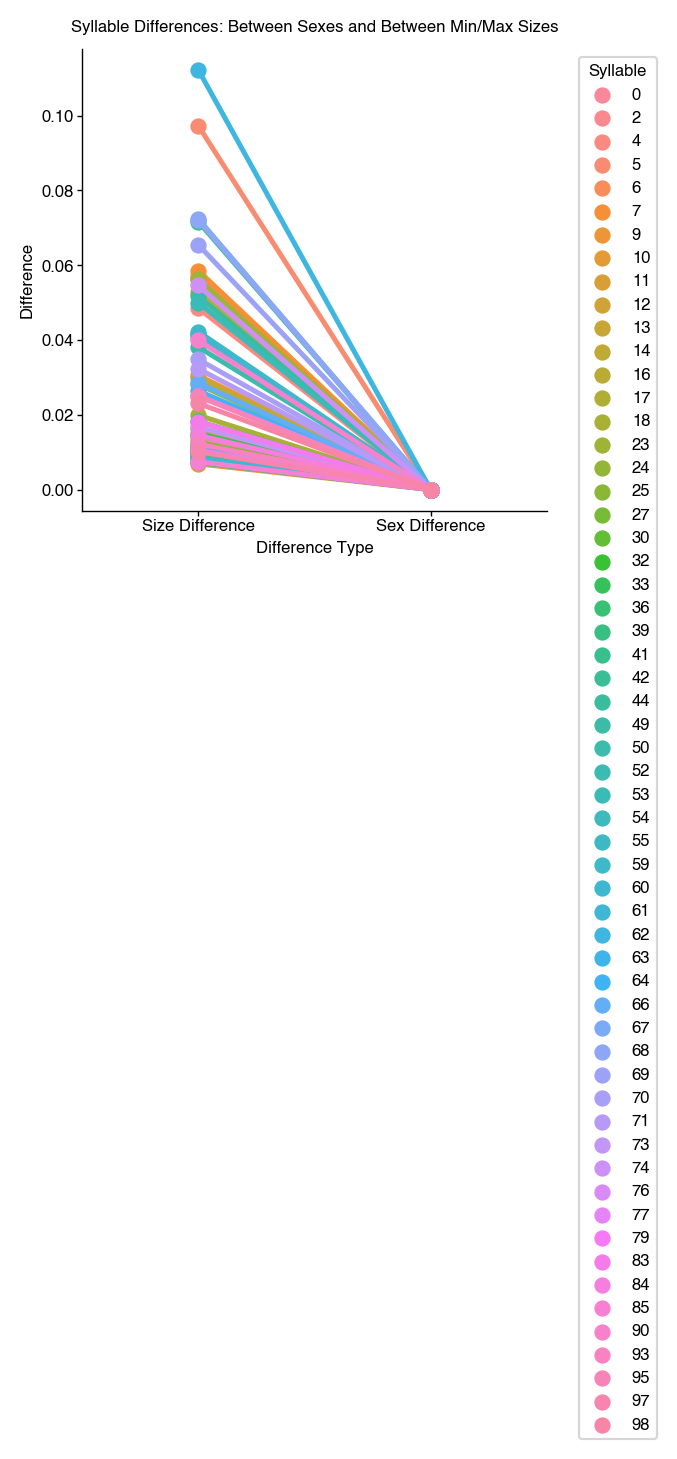

In [40]:
# Initialize lists to store the differences
df = pd.concat([df_male,df_female])
df=df.groupby(['age','uuid','sex','size']).mean()
size_diff = []
sex_diff = []

# Calculate the differences
for column in df.columns:
    # Difference between 0.05 and 0.95 percentiles of size
    lower_percentile = df[column].xs(key=slice(None), level='size').quantile(0.05)
    upper_percentile = df[column].xs(key=slice(None), level='size').quantile(0.95)
    size_diff.append(upper_percentile - lower_percentile)
    
    # Average difference between males and females
    male_mean = df[column].xs(key='m', level='sex').mean()
    female_mean = df[column].xs(key='m', level='sex').mean()
    sex_diff.append(male_mean - female_mean)

# Create DataFrame for plotting
diff_df = pd.DataFrame({
    'Syllable': df.columns,
    'Size Difference': size_diff,
    'Sex Difference': sex_diff
})

# Melt the DataFrame for plotting
melted_df = diff_df.melt(id_vars='Syllable', value_vars=['Size Difference', 'Sex Difference'],
                         var_name='Difference Type', value_name='Difference')

# Plotting
plt.figure(figsize=(3, 3))
sns.pointplot(data=melted_df, x='Difference Type', y='Difference', hue='Syllable', dodge=False, join=True)
plt.title('Syllable Differences: Between Sexes and Between Min/Max Sizes')
plt.xlabel('Difference Type')
plt.ylabel('Difference')
plt.legend(title='Syllable', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()

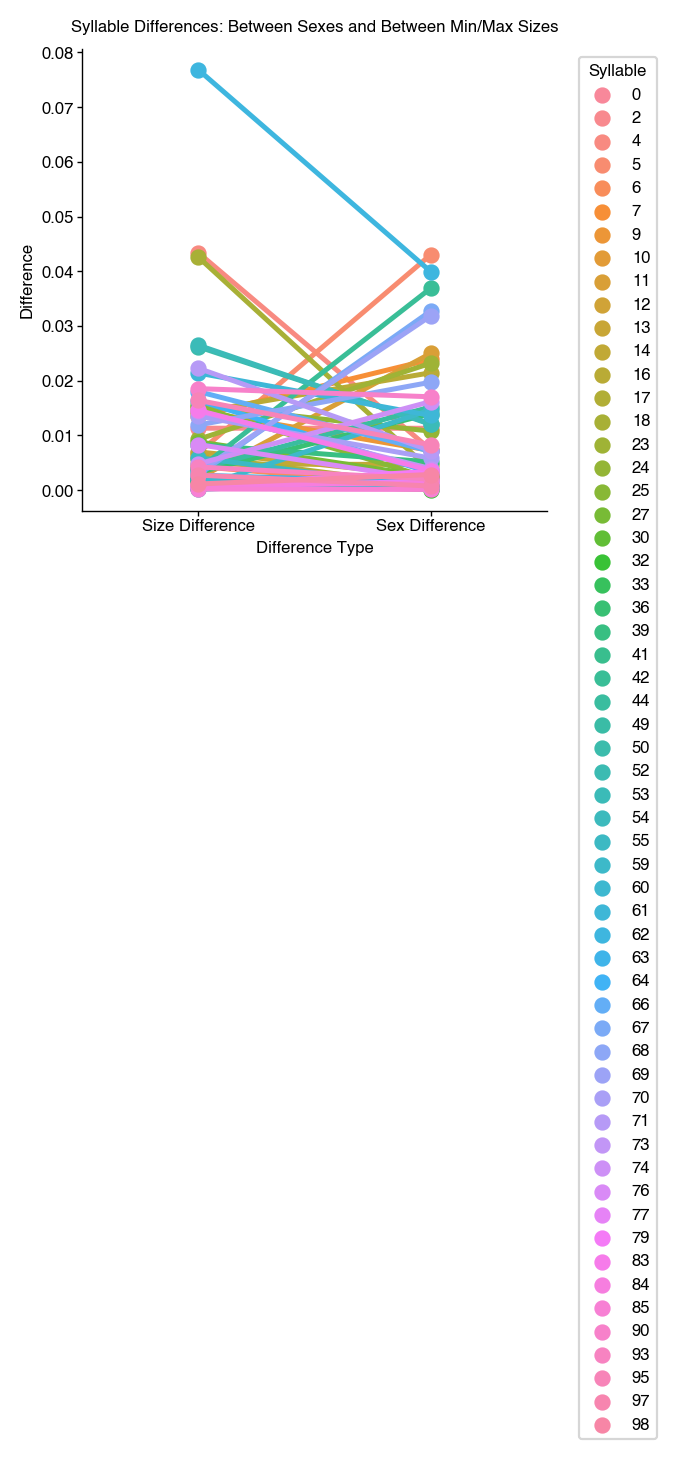

In [41]:
# Initialize lists to store the differences
df = pd.concat([df_male,df_female])
df=df.groupby(['age','uuid','sex','size']).mean()
size_diff = []
sex_diff = []

# Calculate the differences
for column in df.columns:
    # Extract values within the min and max sizes
    min_size = df.index.get_level_values('size').min()
    max_size = df.index.get_level_values('size').max()
    min_size_value = df.xs(key=min_size, level='size')[column].mean()
    max_size_value = df.xs(key=max_size, level='size')[column].mean()
    
    # Calculate difference between the max and min size values
    size_diff.append(np.abs(max_size_value - min_size_value))
    
    # Calculate average difference between males and females
    male_mean = df[column].xs(key='m', level='sex').mean()
    female_mean = df[column].xs(key='f', level='sex').mean()
    sex_diff.append(np.abs(male_mean - female_mean))

# Create DataFrame for plotting
diff_df = pd.DataFrame({
    'Syllable': df.columns,
    'Size Difference': size_diff,
    'Sex Difference': sex_diff
})

# Melt the DataFrame for plotting
melted_df = diff_df.melt(id_vars='Syllable', value_vars=['Size Difference', 'Sex Difference'],
                         var_name='Difference Type', value_name='Difference')

# Plotting
plt.figure(figsize=(3, 3))
sns.pointplot(data=melted_df, x='Difference Type', y='Difference', hue='Syllable', dodge=False, join=True)
plt.title('Syllable Differences: Between Sexes and Between Min/Max Sizes')
plt.xlabel('Difference Type')
plt.ylabel('Difference')
plt.legend(title='Syllable', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()
